In [1]:
# %load_ext autoreload
%autoreload 2

import pickle

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

## Setup: Network Weights and State Computer

In [3]:
# Load the network

from network import NetworkType, Network

# 3-layer LSTM
net = Network(NetworkType.LSTM, input_dim_file='data/onehot_size.npy')
net.set_parameters('data/seqgen_lstm.pkl')
char2ind = pickle.load(open("data/char_to_ind.pkl"))

# SimpleRecurrent LK
# net = Network(input_dim_file='data/lk_onehot_size.npy', hidden_dims=[1024])
# net.set_parameters('data/seqgen_simple_1024-early-stop.pkl')
# char2ind = pickle.load(open('/media/data/lk-no-comments/lk_char2id.pkl'))

# Set up state computer

from util import StateComputer

sc = StateComputer(net.cost_model, char2ind)

In [3]:
aux_var_name = 'sequencegenerator_cost_matrix_states'

##  ERP Analysis

### LK 

In [4]:
import h5py

In [5]:
from sklearn.decomposition import PCA

In [6]:
from collections import defaultdict

def group_indices_by_seq(index_pairs):
    seq_dict = defaultdict(list)
    for seq_idx, item_idx in index_pairs:
        seq_dict[seq_idx].append(item_idx)
    return seq_dict

In [7]:
def chain_seq_states(state_seq_batch):
    # 3d: (batch, seq, hidden_state_size)
    # What we want as a result is an item X state matrix
    # Thus we keep the last dim of state_seq_batch and combine the first two into one
    return state_seq_batch.reshape(-1, state_seq_batch.shape[-1])

In [8]:
def batch_dim_first(state_dict):
    return state_dict[aux_var_name].swapaxes(0, 1)

In [9]:
lk_data = h5py.File('/media/data/lk-no-comments/lk.hdf5')

chars = lk_data['character_seqs']
# corpus_size = len(chars)

In [10]:
indeces = np.where(chars[:,:] == char2ind['{'])

seq_indices = list(set(indeces[0]))
change_seq_indx = dict(zip(seq_indices, range(len(seq_indices))))
orig_indx_pairs = zip(*indeces)
new_indx_pairs = [(change_seq_indx[si], wi) for si, wi in orig_indx_pairs]

# t = group_indices_by_seq(indx_pairs)

In [11]:
zip(*new_indx_pairs[:2])

[(0, 1), (97, 103)]

In [76]:
indx_pairs[:2]

[(2, 97), (3, 103)]

In [70]:
chars[zip(*indx_pairs[:2])]

TypeError: not all arguments converted during string formatting

In [12]:
relevant_states_batch = batch_dim_first(sc.read_sequence_batch(chars[seq_indices[100:300]]))

In [14]:
relevant_states_batch[0][:5]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.84005725, -0.91828352,  0.73823857, ...,  0.29006922,
        -0.14012505,  0.38126493],
       [-0.99907357,  0.80231488,  0.97311008, ...,  0.06220022,
         0.56953937,  0.80606025],
       [-1.        ,  1.        , -1.        , ..., -0.99999946,
         0.99948239,  1.        ],
       [-1.        ,  1.        , -1.        , ..., -1.        ,
         1.        ,  1.        ]], dtype=float32)

In [15]:
relevant_states_batch[zip(*new_indx_pairs[:2])]

array([[-1.,  1., -1., ..., -1.,  1.,  1.],
       [ 1., -1.,  1., ...,  1., -1., -1.]], dtype=float32)

In [48]:
pca = PCA()

In [46]:
transformed = pca.fit_transform(chain_seq_states(relevant_states_batch[aux_var_name]))

In [49]:
pca.fit(chain_seq_states(relevant_states_batch[aux_var_name]))

PCA(copy=True, n_components=None, whiten=False)

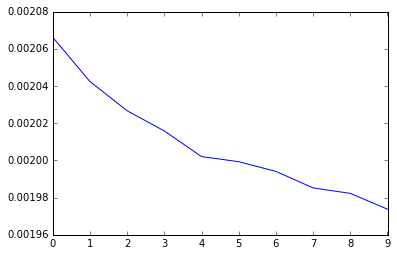

In [52]:
plt.plot(pca.explained_variance_ratio_[:10])

In [51]:
transformed = pca.fit_transform(data)

In [21]:
252 * 20

5040

In [22]:
data = np.random.random((5040, 1024))

In [64]:
pca.components_.shape

(1, 1024)

In [56]:
components.shape

(5040, 1)

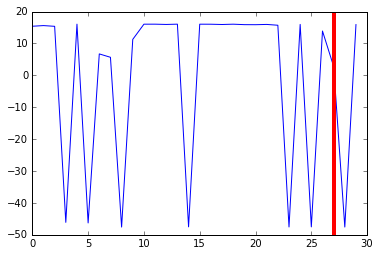

In [53]:
plt.plot(components[70:100])
plt.axvline(x=t[2][0] - 70, linewidth=4, color='r')

In [46]:
t[4]

[133]

In [17]:
chained = chain_seq_states(relevant_states_batch[aux_var_name])

In [18]:
chained.shape

(1260, 1024)

### Single Character detection

load sc, map

select character

generate sequences: character and other characters
in case of bigram exp: character + contexts, other chars + context
wrap these in periods
feed them through sc
select cell/position and average OR we could average for each cell/position

In [15]:
from erputils import ItemIdHelper, item_vs_noise, context_item_vs_noise

In [4]:
tk = ItemIdHelper(map_chr_2_ind)

In [5]:
aux_var_name = "sequencegenerator_cost_matrix_cells#2"

In [11]:
item_states, other_states = item_vs_noise('A', tk, sc)

In [12]:
item_states.keys()

['sequencegenerator_cost_matrix_cells#1',
 'sequencegenerator_cost_matrix_cells#2',
 'sequencegenerator_cost_matrix_states#1',
 'sequencegenerator_cost_matrix_states#2',
 'sequencegenerator_cost_matrix_cells',
 'sequencegenerator_cost_matrix_states']

In [10]:
other_states['sequencegenerator_cost_matrix_cells#1'].mean(axis=0).shape

(512,)

In [42]:
context_it_states, context_other_states = context_item_vs_noise('A', tk, sc)

In [43]:
context_it_states

{'sequencegenerator_cost_matrix_cells': array([[ 0.03464606,  0.91628689,  0.50353211, ..., -0.47803751,
         -0.98307621, -0.15884028],
        [-1.07778621,  0.90315723,  0.55432594, ..., -0.62551844,
         -0.6449002 ,  0.45704916],
        [-1.74003315,  0.16603877,  0.0953985 , ..., -0.01395062,
         -0.1360615 ,  1.25826013],
        ..., 
        [ 0.06487142,  0.90870166,  0.10279412, ..., -0.0671764 ,
         -0.81281036, -0.17809001],
        [ 0.05325152,  1.00607312,  0.93537378, ..., -0.29988942,
         -1.12448192, -0.05740561],
        [-0.38449222,  0.35730359,  0.30025905, ...,  0.24882995,
         -0.26510844,  0.00533883]], dtype=float32),
 'sequencegenerator_cost_matrix_cells#1': array([[-1.61728406, -0.88043696,  1.87153637, ..., -0.58676714,
          0.01444731,  0.63314819],
        [-0.24869415, -0.5455901 ,  1.40073586, ..., -0.98614609,
         -0.01853268, -0.01298802],
        [ 0.69552273,  0.6549446 ,  1.53332722, ...,  0.55622685,
       

In [20]:
map(tk.add_period, tk.add_context([9]))

[array([ 8,  9, 31]),
 array([24,  9, 31]),
 array([23,  9, 31]),
 array([72,  9, 31]),
 array([ 5,  9, 31]),
 array([63,  9, 31]),
 array([71,  9, 31]),
 array([70,  9, 31]),
 array([76,  9, 31]),
 array([74,  9, 31]),
 array([37,  9, 31]),
 array([31,  9, 31]),
 array([25,  9, 31]),
 array([53,  9, 31]),
 array([41,  9, 31]),
 array([32,  9, 31]),
 array([44,  9, 31]),
 array([43,  9, 31]),
 array([49,  9, 31]),
 array([48,  9, 31]),
 array([52,  9, 31]),
 array([50,  9, 31]),
 array([38,  9, 31]),
 array([16,  9, 31]),
 array([61,  9, 31]),
 array([33,  9, 31]),
 array([17,  9, 31]),
 array([11,  9, 31]),
 array([54,  9, 31]),
 array([45,  9, 31]),
 array([21,  9, 31]),
 array([ 6,  9, 31]),
 array([26,  9, 31]),
 array([51,  9, 31]),
 array([69,  9, 31]),
 array([66,  9, 31]),
 array([15,  9, 31]),
 array([42,  9, 31]),
 array([56,  9, 31]),
 array([47,  9, 31]),
 array([75,  9, 31]),
 array([58,  9, 31]),
 array([40,  9, 31]),
 array([57,  9, 31]),
 array([62,  9, 31]),
 array([ 2

### All of Bible data

In [44]:
import h5py()

In [45]:
bible = h5py.File('data/bible.hdf5')

In [53]:
from util import pad_mask

In [57]:
pad_bible = pad_mask(bible['character_seqs'][:50])

In [58]:
test_state = sc.read_sequence_batch(*pad_bible)

In [60]:
test_state['sequencegenerator_cost_matrix_cells#1'].shape

(264, 50, 512)

## Basic facts about cost-matrix output

### First states == initial states

In [4]:
# Something nice to print at each iteration
msg = "Is the <{}> variable equal to its initial value after any random char?\n{}"
model_initial_vals = lstm_net.cost_model.get_parameter_values()
name_converter = {
    'sequencegenerator_cost_matrix_cells':
    '/sequencegenerator/with_fake_attention/transition/layer#0.initial_cells',
    'sequencegenerator_cost_matrix_cells#1':
    '/sequencegenerator/with_fake_attention/transition/layer#1.initial_cells',
    'sequencegenerator_cost_matrix_cells#2':
    '/sequencegenerator/with_fake_attention/transition/layer#2.initial_cells',
    'sequencegenerator_cost_matrix_states':
    '/sequencegenerator/with_fake_attention/transition/layer#0.initial_state',
    'sequencegenerator_cost_matrix_states#1':
    '/sequencegenerator/with_fake_attention/transition/layer#1.initial_state',
    'sequencegenerator_cost_matrix_states#2':
    '/sequencegenerator/with_fake_attention/transition/layer#2.initial_state' 
}
# read every char in vocab
reading_singleton_seqs = [sc.read_single_sequence([char_id]) for char_id in map_chr_2_ind.values()]
for state_name in sc.state_var_names:
    # getting initial value of variable
    initial_val = model_initial_vals[name_converter[state_name]]
    read_vals = [val[state_name] for val in reading_singleton_seqs]
    print(msg.format(state_name, all(np.all(v == initial_val) for v in read_vals)))

Is the <sequencegenerator_cost_matrix_cells> variable equal to its initial value after any random char?
True
Is the <sequencegenerator_cost_matrix_cells#1> variable equal to its initial value after any random char?
True
Is the <sequencegenerator_cost_matrix_cells#2> variable equal to its initial value after any random char?
True
Is the <sequencegenerator_cost_matrix_states> variable equal to its initial value after any random char?
True
Is the <sequencegenerator_cost_matrix_states#1> variable equal to its initial value after any random char?
True
Is the <sequencegenerator_cost_matrix_states#2> variable equal to its initial value after any random char?
True


### States One Step Behind
At position *t* states/cells reflect input at *t-1*

In [5]:
period_id = map_chr_2_ind['.']
# we vary only the first char in the sequence, the second one stays the same.
bigram_seqs = [(char_id, period_id) for char_id in map_chr_2_ind.values()]
reading_bigrams = [sc.read_single_sequence(bs) for bs in bigram_seqs]
for state_name in sc.state_var_names:
    for pos in (0, 1):
        read_vals = [val[state_name][pos] for val in reading_bigrams]
        print('Are values for <{}> at pos {} equal amongst themselves?'.format(state_name, pos))
        print(np.array_equal(read_vals[1:], read_vals[:-1]))

Are values for <sequencegenerator_cost_matrix_cells> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_cells> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_cells#1> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_cells#1> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_cells#2> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_cells#2> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_states> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_states> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_states#1> at pos 0 equal amongst themselves?
True
Are values for <sequencegenerator_cost_matrix_states#1> at pos 1 equal amongst themselves?
False
Are values for <sequencegenerator_cost_matrix_sta

### Hinton Diagrams

In [7]:
from stoogeplot import hinton_diagram

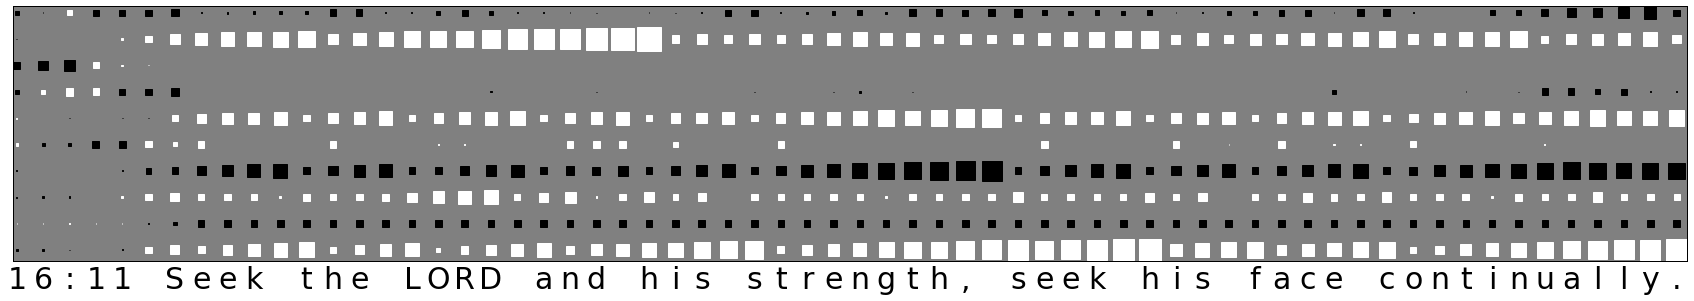

In [13]:
f = plt.figure(figsize=(30, 30))
ax = hinton_diagram(demo_cell[:,:10], xticks=demo_sent)
f.subplots_adjust(bottom=0.2)

In [6]:
# samples in range [-1, 1)
randy = 2 * np.random.random(size=(20, 20),) -1

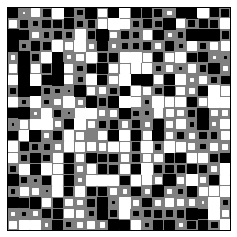

In [29]:
hinton_diagram(randy)

## WIP: Faster Hinton plot drawing!

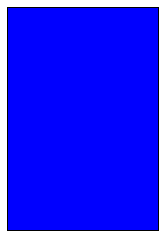

In [13]:
max_weight = 2 ** np.ceil(np.log(np.abs(randy).max()) / np.log(2))

vertices = []
sizes = []
for (x, y), val in np.ndenumerate(randy):
    s = np.sqrt(np.abs(val) / max_weight)
    h = s / 2
    bottom_left = [x - h, y - h]
    top_left = [x - h, y + h]
    top_right = [x + h, y + h]
    bottom_right = [x + h, y - h]
    vertices.append(np.array([
                bottom_left,
                top_left,
                top_right,
                bottom_right
            ]))
    sizes.append(s)

from matplotlib.collections import PolyCollection

pc = PolyCollection(vertices, sizes)

# This currently plots one big rectangle
f = plt.gcf()
ax = f.add_subplot(1,1,1)
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
# Not interested in yaxis ticks
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.add_collection(pc)
ax.autoscale_view()

## Old Demo

In [6]:
aux_var_name = "sequencegenerator_cost_matrix_cells#2"

In [13]:
# demo_sent = "13:2 And Abram was very rich in cattle, in silver, and in gold."
# demo_sent = "16:11 Seek the LORD and his strength, seek his face continually."
# demo_sent = "cats eat mice."
# second_demo_sent = "cats eat flies"
# the problem about this sentence is that I cannot see the difference between end of seq and closing bracket
demo_seqs = ['static void pfn_inject_exit(void)\n{\n        debugfs_remove_recursive(hwpoison_dir);\n}',
            'static int follow_pfn_pte(struct vm_area_struct *vma, unsigned long address,\n                pte_t *pte, unsigned int flags)\n{\n        /* No page to get reference */\n        if (flags & FOLL_GET)\n                return -EFAULT;\n\n        if (flags & FOLL_TOUCH) {\n                pte_t entry = *pte;\n\n                if (flags & FOLL_WRITE)\n                        entry = pte_mkdirty(entry);\n                entry = pte_mkyoung(entry);\n\n                if (!pte_same(*pte, entry)) {\n                        set_pte_at(vma->vm_mm, address, pte, entry);\n                        update_mmu_cache(vma, address, pte);\n                }\n        }\n\n        /* Proper page table entry exists, but no corresponding struct page */\n        return -EEXIST;\n}\n', 
            'if (flags & FOLL_GET) {\n                get_page(page);\n\n                /* drop the pgmap reference now that we hold the page */\n                if (pgmap) {\n                        put_dev_pagemap(pgmap);\n                        pgmap = NULL;\n                }\n        }',
            'if (flags & FOLL_SPLIT) {\n                int ret;\n                page = pmd_page(*pmd);\n                if (is_huge_zero_page(page)) {\n                        spin_unlock(ptl);\n                        ret = 0;\n                        split_huge_pmd(vma, pmd, address);\n                } else {\n                        get_page(page);\n                        spin_unlock(ptl);\n                        lock_page(page);\n                        ret = split_huge_page(page);\n                        unlock_page(page);\n                        put_page(page);\n                }\n\n                return ret ? ERR_PTR(ret) :\n                        follow_page_pte(vma, address, pmd, flags);\n        }',
            'e'*600]
demo_seq = demo_seqs[3]

In [27]:
# demo_computed_vars = sc.read_single_sequence(demo_seq.replace(' ', 'a'))  # <- there are cells around, that react differently depending on the replacement char
demo_computed_vars = sc.read_single_sequence(demo_seq)

In [28]:
demo_cell = demo_computed_vars[aux_var_name]

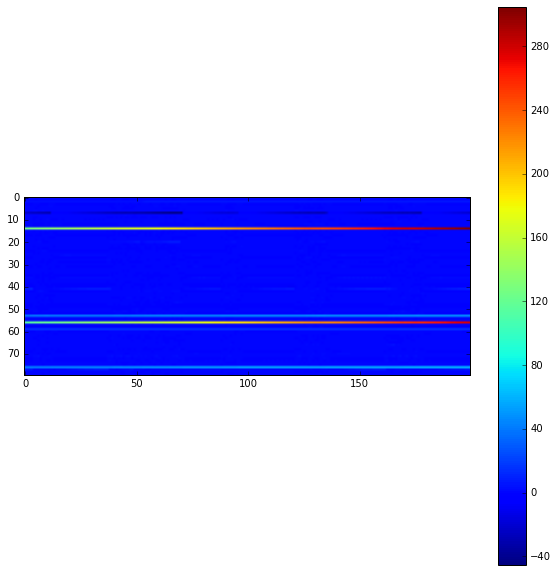

In [29]:
from scipy.misc import imshow as show_image

plt.figure(figsize=(10, 10))
plt.imshow(demo_cell[200:400,100:180].T)
plt.colorbar()

### Plotting Stuff...

This for now is just a demo of how easy it is to get at the various components of an NN and plot them

In [4]:
cats_mice = sc.read_single_sequence("cats eat mice")

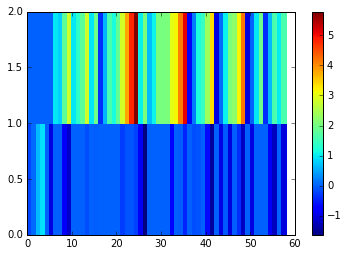

In [23]:
# f = plt.figure(figsize=(20, 20))
# plt.pcolormesh(np.expand_dims(third_cell[0][0], axis=0))
plt.pcolormesh(abram_cell2_simple[:,18:20].T)
# sets char IDs as tick labels on the X axis
# plt.xticks(input_positions, list("cats eat mice"))
# plt.yticks([])
# plt.ylim(0, 0.1)
plt.colorbar()
plt.show()

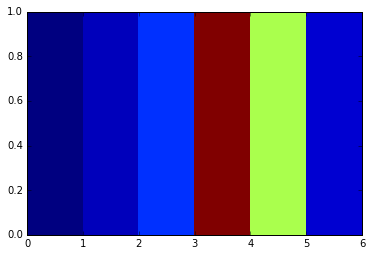

In [3]:
plt.pcolormesh(np.random.rand(1, 6))
plt.show()

## ICA

For now not used.

In [19]:
from sklearn.decomposition import FastICA

ica = FastICA()

# Crashes kernel atm
src = ica.fit_transform(demo_cell)

## Developing Conll Marking func

Cleaned up here mostly, but leaving some basics in case debugging needst to happen.

In [3]:
from dataproc import load_tab_delim_hdt

from util import dependencies, simple_mark_dependency

In [3]:
f_path = '/media/data/hamburg-dependency-treebank-conll'
file_tpl = 'part_{}.conll'

In [4]:
hdtgr = load_tab_delim_hdt(f_path + '/' + file_tpl.format('C'))

/home/quickbeam/ilia_dev/python/miniconda/envs/nltk3/lib/python3.5/site-packages/nltk/parse/dependencygraph.py:378: UserWarning: The graph doesn't contain a node that depends on the root element.
  "The graph doesn't contain a node "


### Generating Stuff (cleanly!)

In [25]:
gen = lstm_net.cost_model.get_top_bricks()[-1]

In [27]:
from blocks.graph import ComputationGraph

In [28]:
sampler = ComputationGraph(gen.generate(n_steps=10, batch_size=1, iterate=True)).get_theano_function()

In [31]:
s = sampler()

In [36]:
[x.shape for x in s]

[(10, 1, 512),
 (10, 1, 512),
 (10, 1, 512),
 (10, 1, 512),
 (10, 1, 512),
 (10, 1, 512),
 (10, 1),
 (10, 1)]

In [38]:
gen._state_names

['states', 'cells', 'states#1', 'cells#1', 'states#2', 'cells#2']

In [39]:
s2 = sampler()

In [45]:
np.array_equal(s2[-2], s[-2])

False

## Linux Kernel prep to train

In [3]:
lk_vocab = np.load('/media/data/lk-no-comments/lk_ix2char.npy')

In [ ]:
np.save('data/lk_onehot_size.npy', 96)

In [20]:
np.load('data/lk_onehot_size.npy')

array(96)

In [13]:
v_bible = np.load('data/onehot_size.npy')

In [17]:
v_bible

array(77L, dtype=int64)